# <font color=black>**Wazobia Real Estate: Predictive Model**</code> 

## Notebook Content
   
* Wazobia Real Estate: Predictive Model
* Notebook Content
* 1. Overview
    * Introduction
    * Data Description
* 2. Exploratory Data Analysis
    * Descriptive Analysis
    * Univariate Analysis
    * Bivariate Analysis
    * EDA Inferences
* 3. Feature Engineering
* 4. Modeling

## 1. Overview

### Introduction
Wazobia Real Estate Limited is a prominent real estate company operating in Nigeria. With a vast portfolio of properties, they strive to provide accurate and competitive pricing for houses. However, they have been facing challenges in accurately predicting the prices of houses in the current market. To overcome this hurdle, Wazobia Real Estate Limited need a robust predictive model.

The objective of this model is to create an accurate predictive model that can estimate the prices of houses in Nigeria. By leveraging the provided dataset, we will analyze various factors that impact house prices, identify meaningful patterns, and build a model that can generate reliable price predictions. The ultimate goal is to provide Wazobia Real Estate Limited with an effective tool to make informed pricing decisions and enhance their competitiveness in the market.

### Data Description

There are ~14000 entries in Train and ~6000 entries in Test Dataset.
The objective of the challenge is to predict the price (Amount (Million Naira) the company should sell a house based on the available data (ID, Location, , Amount (Million Naira), Bathroom, Bedroom, Parking space).

#### **About the Data:-**
The data contains the following columns:-

| Column Name | Description |
|:------------|:------------|
| ID | Unique identifier |
| Loc | House Location |
| Title | Type of house |
| Bedroom | Number of bedrooms in the house |
| Bathroom | Number of bathrooms in the house |
| Parking space | Number of available parking space |
| Price | The house price (Our Label) |


Based on the above house characteristics we need to predict the house price.  

We will make use of pandas and LightGBM throughout this demo.

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

# Built-in library
import itertools
import typing as tp

# pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 1_000

import warnings

warnings.filterwarnings("ignore")

# Black code formatter
%load_ext lab_black

In [2]:
# Load dataset
file_path = "Data\Housing_dataset_train.csv"

train_df = pd.read_csv(file_path)
test_df = pd.read_csv("Data\Housing_dataset_test.csv")
sample_sub = pd.read_csv("Data\Sample_submission.csv")

print("Data loaded successfully!")

Data loaded successfully!


# 2. EDA

## Descriptive Analysis

In [3]:
# View 8 samples

train_df.sample(8)

,ID,loc,title,bedroom,bathroom,parking_space,price
7765,4832,Rivers,Detached duplex,5.0,6.0,NaN,3.336336e+06
11344,643,NaN,Cottage,5.0,1.0,4.0,1.150984e+06
12407,2145,NaN,Townhouse,9.0,7.0,4.0,3.325973e+06
5269,164,Abia,NaN,1.0,1.0,2.0,6.085952e+05
5810,4649,NaN,Apartment,7.0,2.0,6.0,1.764477e+06
2229,772,NaN,Detached duplex,NaN,2.0,3.0,2.084648e+06
3131,11487,Delta,NaN,9.0,3.0,5.0,3.640543e+06
11801,888,Taraba,Apartment,9.0,7.0,2.0,2.362321e+06


In [4]:
# Sum of missing values

missing_data = train_df.isna().sum().to_frame().rename(columns={0: "EmptyCells"})
missing_data

,EmptyCells
ID,0
loc,1813
title,1722
bedroom,1799
bathroom,1805
parking_space,1811
price,0


In [5]:
# Quick summary of numeric features

train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,14000.0,4.862700e+03,3.818348e+03,0.00,1.672750e+03,3.527000e+03,8011.250,12999.00
bedroom,12201.0,4.308171e+00,2.441165e+00,1.00,2.000000e+00,4.000000e+00,6.000,9.00
bathroom,12195.0,3.134235e+00,2.035950e+00,1.00,1.000000e+00,2.000000e+00,5.000,7.00
parking_space,12189.0,3.169825e+00,1.599415e+00,1.00,2.000000e+00,3.000000e+00,4.000,6.00
price,14000.0,2.138082e+06,1.083057e+06,431967.29,1.393990e+06,1.895223e+06,2586699.494,16568486.16


In [6]:
# Quick summary of categorical features

train_df.describe(include="O").T

,count,unique,top,freq
loc,12187,36,Kaduna,370
title,12278,10,Flat,1372


## Univariate Analysis

In [7]:
# Group features into categorical & numerical
cat_features = ["loc", "title"]

num_features = ["bedroom", "bathroom", "parking_space"]

In [8]:
# Using a bar plot function to plot categorical data distribution


def bar_chart(var):
    """This function is for plotting bar charts"""
    plt.figure(figsize=(8, 5))
    train_df[var].value_counts().plot(kind="bar")
    plt.ylabel(f"Count of {var}")
    plt.title(f"Distribution of {var}")
    plt.show()

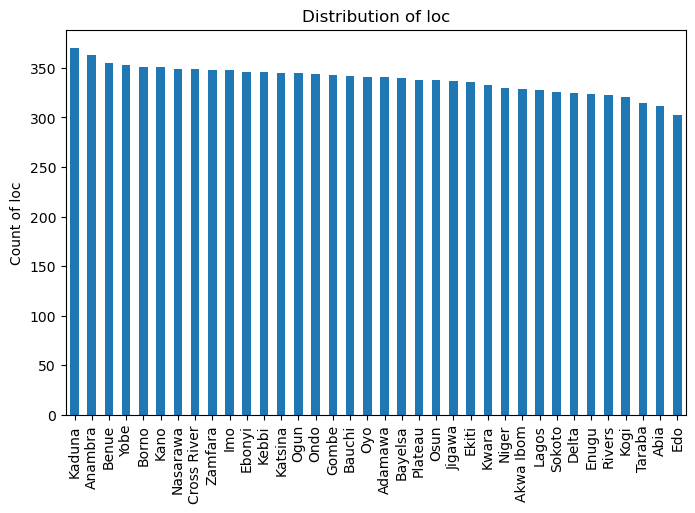

In [9]:
# House location distribution

bar_chart("loc")

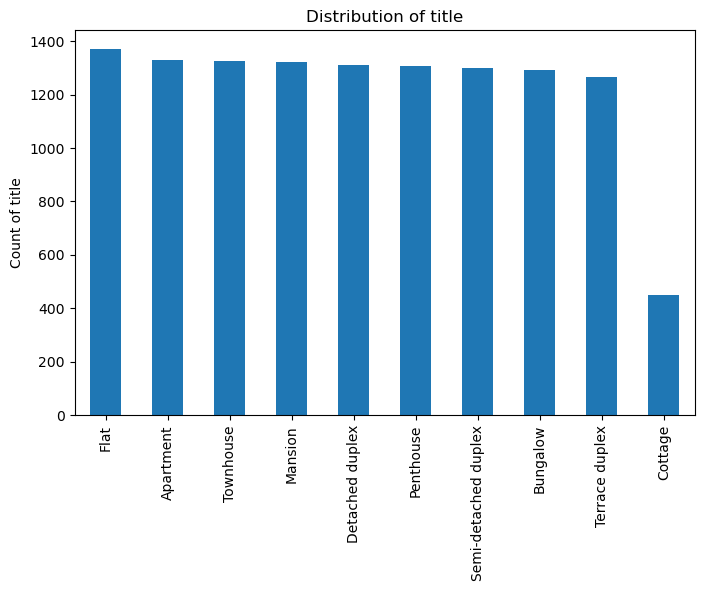

In [10]:
# House types distribution

bar_chart("title")

<Axes: title={'center': 'Box Plot of Numeric Features'}>

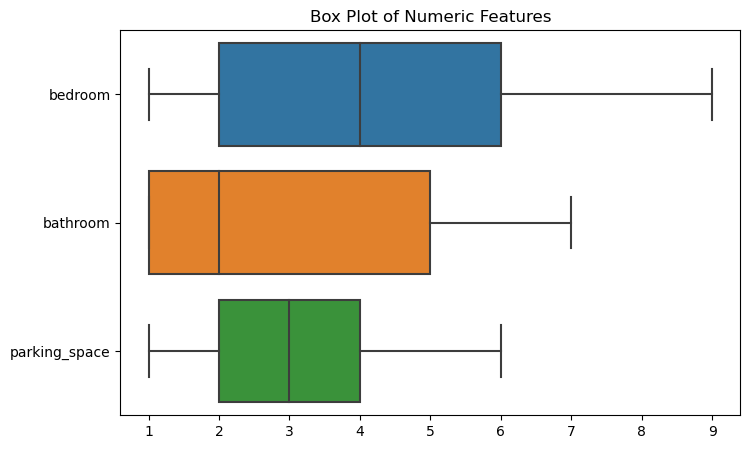

In [11]:
# Box plot of bedroom, bathroom, & parking space

plt.figure(figsize=(8, 5))
plt.title("Box Plot of Numeric Features")
sns.boxplot(data=train_df[num_features], orient="h")

<Axes: title={'center': 'Box Plot of House prices'}>

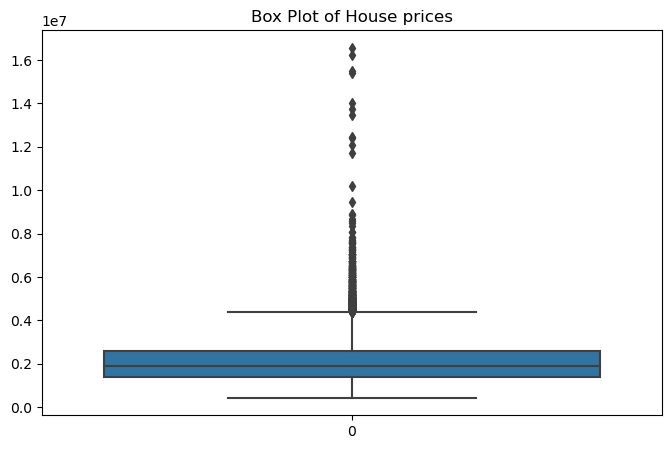

In [12]:
# Box plot of House prices
plt.figure(figsize=(8, 5))
plt.title("Box Plot of House prices")
sns.boxplot(data=train_df["price"])

## Bivariate Analysis

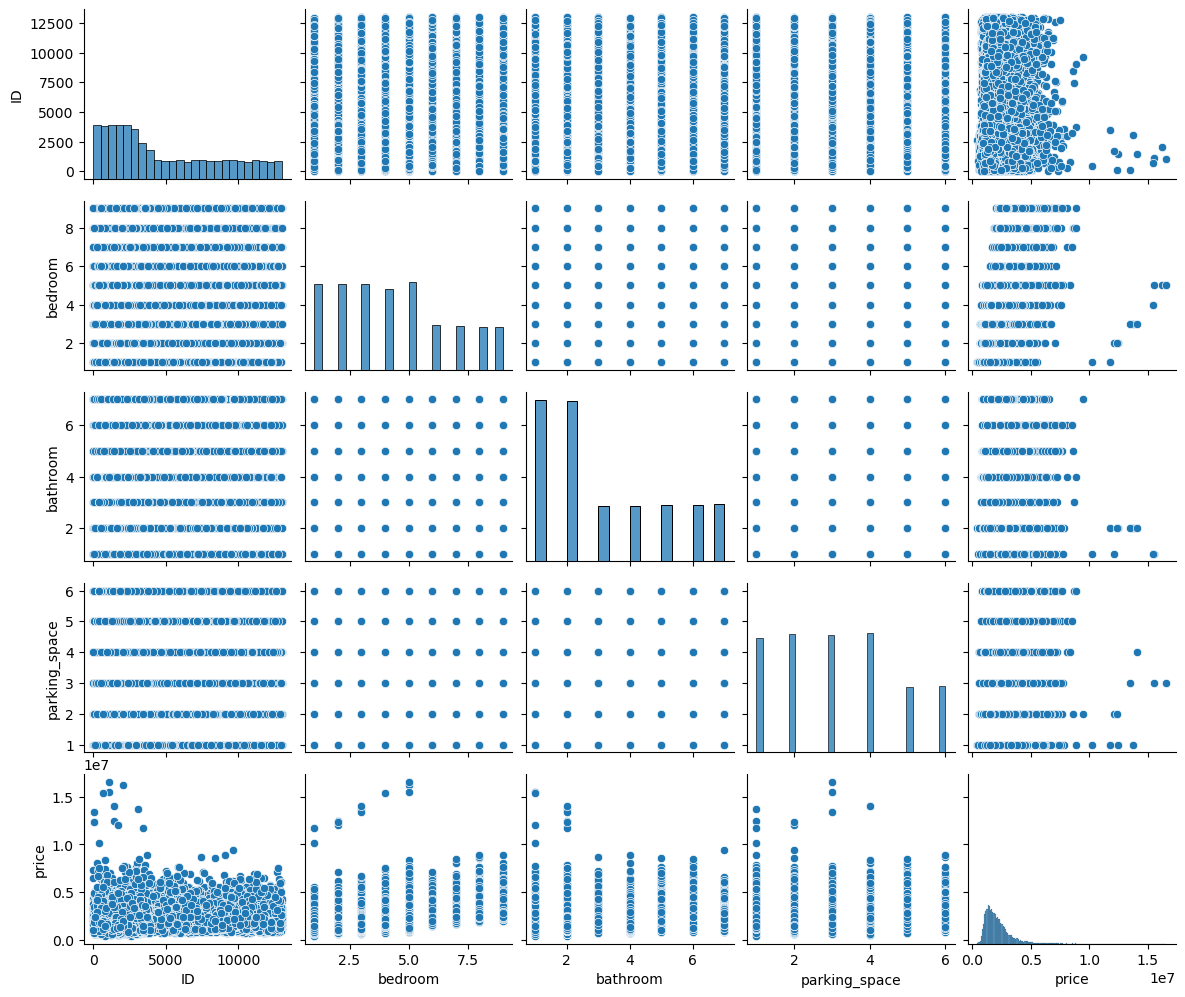

In [13]:
# Pairplot

g = sns.pairplot(train_df)
g.fig.set_size_inches(12, 10)

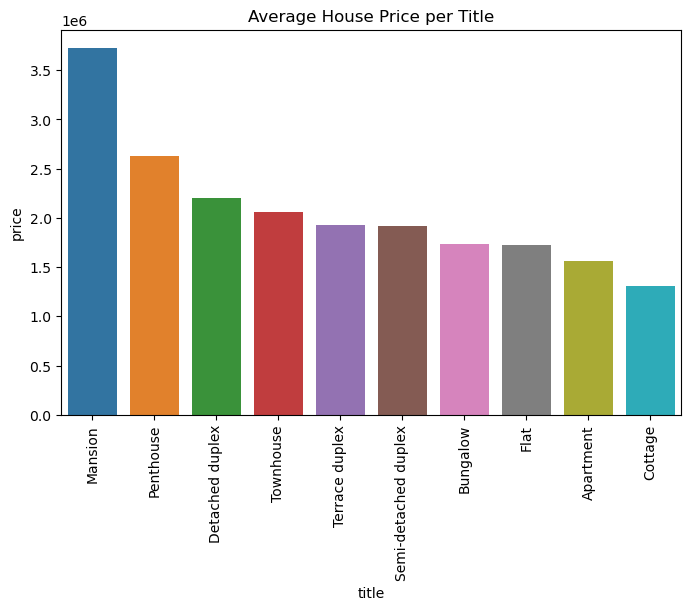

In [14]:
# Mean price per title

avg_price_per_title = train_df.groupby("title")["price"].mean().reset_index()

sort = avg_price_per_title.sort_values(by="price", ascending=False)

# bar_chart(avg_price_per_title)
plt.figure(figsize=(8, 5))
sns.barplot(data=sort, x="title", y="price")
plt.title("Average House Price per Title")
plt.xticks(rotation=90)
plt.show()

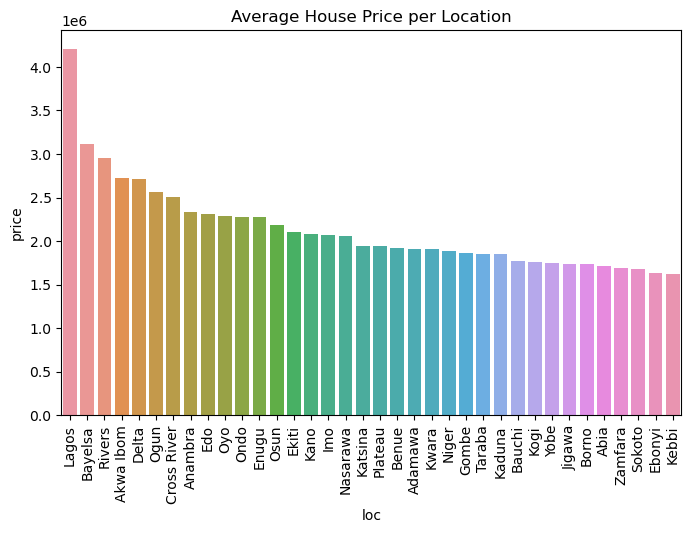

In [15]:
# Mean price per loc

avg_price_per_loc = train_df.groupby("loc")["price"].mean().reset_index()

sort = avg_price_per_loc.sort_values(by="price", ascending=False)

# bar_chart(avg_price_per_title)
plt.figure(figsize=(8, 5))
sns.barplot(data=sort, x="loc", y="price")
plt.title("Average House Price per Location")
plt.xticks(rotation=90)
plt.show()

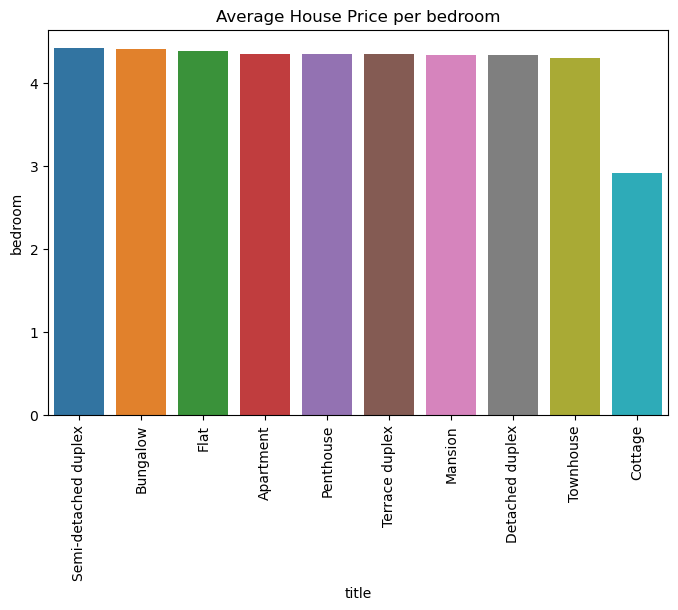

In [16]:
# Mean bedroom per title

avg_price_per_title = train_df.groupby("title")["bedroom"].mean().reset_index()

sort = avg_price_per_title.sort_values(by="bedroom", ascending=False)

# bar_chart(avg_price_per_title)
plt.figure(figsize=(8, 5))
sns.barplot(data=sort, x="title", y="bedroom")
plt.title("Average House Price per bedroom")
plt.xticks(rotation=90)
plt.show()

<Axes: >

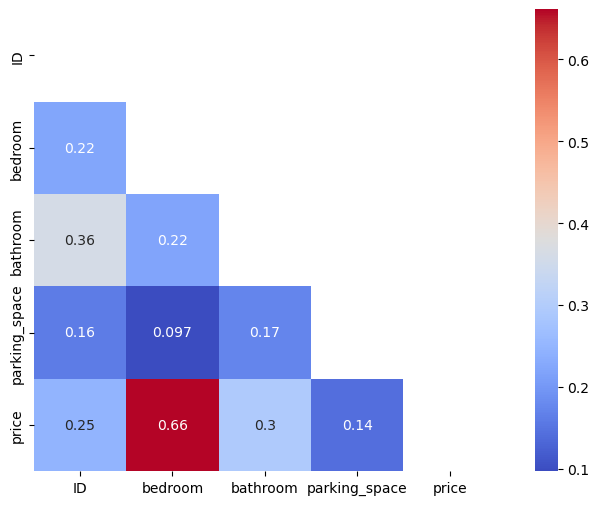

In [17]:
plt.figure(figsize=(10, 6))
corr = train_df.corr(method="spearman", numeric_only=True)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, square=True, cmap="coolwarm", annot=True)

## EDA Inferences:-

1. We have a mean house price of about 2.2 million naira.
2. Lagos have the most expensive houses
3. Mansion is the most expensive house type
4. The disparity in the house prices is expected in this context. Has houses prices tend to vary based on some characteristis. 
5. Bedroom size seem to be almost equal for all house type except cottage.
6. There seem to be a moderate relationship between bedroom size and house prices only. As there is a very low level of correlation between most the features.


# 3. Feature Engineering

In [18]:
# Join test and train features
df = train_df.drop("price", axis=1).append(test_df)
clean_df = df.copy()

In [19]:
# Drop irrelevant features
clean_df.drop(["ID"], axis=1, inplace=True)

In [20]:
# Create new feature, group location to regions

loc_region = {
    "Abia": "South-East",
    "Adamawa": "North-East",
    "Akwa Ibom": "South-South",
    "Anambra": "South-East",
    "Bauchi": "North-East",
    "Bayelsa": "South-South",
    "Benue": "North-Central",
    "Borno": "North-East",
    "Cross River": "South-South",
    "Delta": "South-South",
    "Ebonyi": "South-East",
    "Edo": "South-South",
    "Ekiti": "South-West",
    "Enugu": "South-East",
    "Gombe": "North-East",
    "Imo": "South-East",
    "Jigawa": "North-West",
    "Kaduna": "North-West",
    "Kano": "North-West",
    "Katsina": "North-West",
    "Kebbi": "North-West",
    "Kogi": "North-Central",
    "Kwara": "North-Central",
    "Lagos": "South-West",
    "Nasarawa": "North-Central",
    "Niger": "North-Central",
    "Ogun": "South-West",
    "Ondo": "South-West",
    "Osun": "South-West",
    "Oyo": "South-West",
    "Plateau": "North-Central",
    "Rivers": "South-South",
    "Sokoto": "North-West",
    "Taraba": "North-East",
    "Yobe": "North-East",
    "Zamfara": "North-West",
}

# Create a new column 'Region' by mapping the locations to their respective regions
clean_df["region"] = clean_df["loc"].map(loc_region)

In [21]:
# Rank region
# Calculate the frequency of each region
reg_counts = clean_df["region"].value_counts()

# Create a dictionary to store the rank of each region
reg_rank = {title: x for x, title in enumerate(reg_counts.index, start=1)}

# mapping the region to their ranks
clean_df["region"] = clean_df["region"].map(reg_rank)

In [22]:
# Rank House types
# Calculate the frequency of each house type
title_counts = clean_df["title"].value_counts()

# Create a dictionary to store the rank of each house type
title_rank = {title: x for x, title in enumerate(title_counts.index, start=1)}

# mapping the house types to their ranks
clean_df["title"] = clean_df["title"].map(title_rank)

In [23]:
# Create new features
# Bedroom to Bathroom ratio
# Calculate the Bedroom to Bathroom ratio
clean_df["bedroom_bathroom_ratio"] = clean_df["bedroom"] / clean_df["bathroom"]

# Bedroom to Parking space ratio
clean_df["bedroom_park_ratio"] = clean_df["bedroom"] / clean_df["parking_space"]

In [24]:
# Get frequency of the categories in the location feature
cat_freq = clean_df["loc"].value_counts(normalize=True)

# Create dictionary
loc_freq_dict = cat_freq.to_dict()

# Map locations to the corresponding values
clean_df["loc"] = clean_df["loc"].map(loc_freq_dict)

# Print the updated dataframe
# clean_df.head()

In [25]:
# Separating Train & Test features

# First 14000(shape of train) rows
X = clean_df[: train_df.shape[0]]

# Price column(label)
y = train_df.price

# Last 6000(shape of test) rows
test_df1 = clean_df[train_df.shape[0] :]

# 4. Modeling

In [26]:
# Split the data into training and testing

RANDOM_STATE, TEST_SIZE = 42, 0.2
TARGET = "price"


X_train, X_validation, y_train, y_validation = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

X_train.shape, X_validation.shape, y_train.shape

((11200, 8), (2800, 8), (11200,))

In [27]:
lgb = LGBMRegressor()
lgb.fit(X_train, y_train)
lgb_pred = lgb.predict(X_validation)


# Root Mean Squared Error (The lower, the better)
rmse = mean_squared_error(y_true=y_validation, y_pred=lgb_pred, squared=False)
rmse

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001637 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 163
[LightGBM] [Info] Number of data points in the train set: 11200, number of used features: 8
[LightGBM] [Info] Start training from score 2135673.350592


598553.4750274013

In [28]:
predictions = lgb.predict(test_df1)
predictions

array([2245801.03449117,  945179.57502377, 1194097.34967633, ...,
       2006491.79516038, 1338858.03578653, 3132257.99302424])

In [29]:
sample_sub["price"] = predictions
# sample_sub.head()

In [30]:
# Cross validation using kfold
# Perform log transformation on the target variable 'price'

fold_pred = []
oof_pred = []


params = {
    "n_estimators": 500,
    "colsample_bytree": 0.86,
    "learning_rate": 0.032,
    "max_depth": 7,
    "subsample": 0.85,
}


fold = KFold(n_splits=5, shuffle=True)
i = 1
for train_index, test_index in fold.split(X, y):
    X_train, X_validation = X.iloc[train_index], X.iloc[test_index]
    y_train, y_validation = np.log1p(y.iloc[train_index]), y.iloc[test_index]

    model = LGBMRegressor(
        **params, objective="rmse", num_leaves=20, force_col_wise=True
    )
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_train, y_train), (X_validation, y_validation)],
    )

    preds = model.predict(X_validation)
    print(
        "err: ", (mean_squared_error(y_validation, np.expm1(preds), squared=False))
    )  # Reverse transformation
    oof_pred.append(mean_squared_error(y_validation, np.expm1(preds), squared=False))
    p2 = model.predict(test_df1[X.columns])
    fold_pred.append(np.expm1(p2))


print(np.mean(oof_pred))

[LightGBM] [Info] Total Bins 163
[LightGBM] [Info] Number of data points in the train set: 11200, number of used features: 8
[LightGBM] [Info] Start training from score 14.468577
err:  535460.3278074634
[LightGBM] [Info] Total Bins 163
[LightGBM] [Info] Number of data points in the train set: 11200, number of used features: 8
[LightGBM] [Info] Start training from score 14.472060
err:  522412.61980125884
[LightGBM] [Info] Total Bins 163
[LightGBM] [Info] Number of data points in the train set: 11200, number of used features: 8
[LightGBM] [Info] Start training from score 14.470856
err:  549376.128443485
[LightGBM] [Info] Total Bins 163
[LightGBM] [Info] Number of data points in the train set: 11200, number of used features: 8
[LightGBM] [Info] Start training from score 14.473390
err:  521719.8703511856
[LightGBM] [Info] Total Bins 163
[LightGBM] [Info] Number of data points in the train set: 11200, number of used features: 8
[LightGBM] [Info] Start training from score 14.474477
err:  583

In [31]:
# 544803.2606826873

Text(0.5, 1.0, 'CatboostClassifier features importance (top 50):')

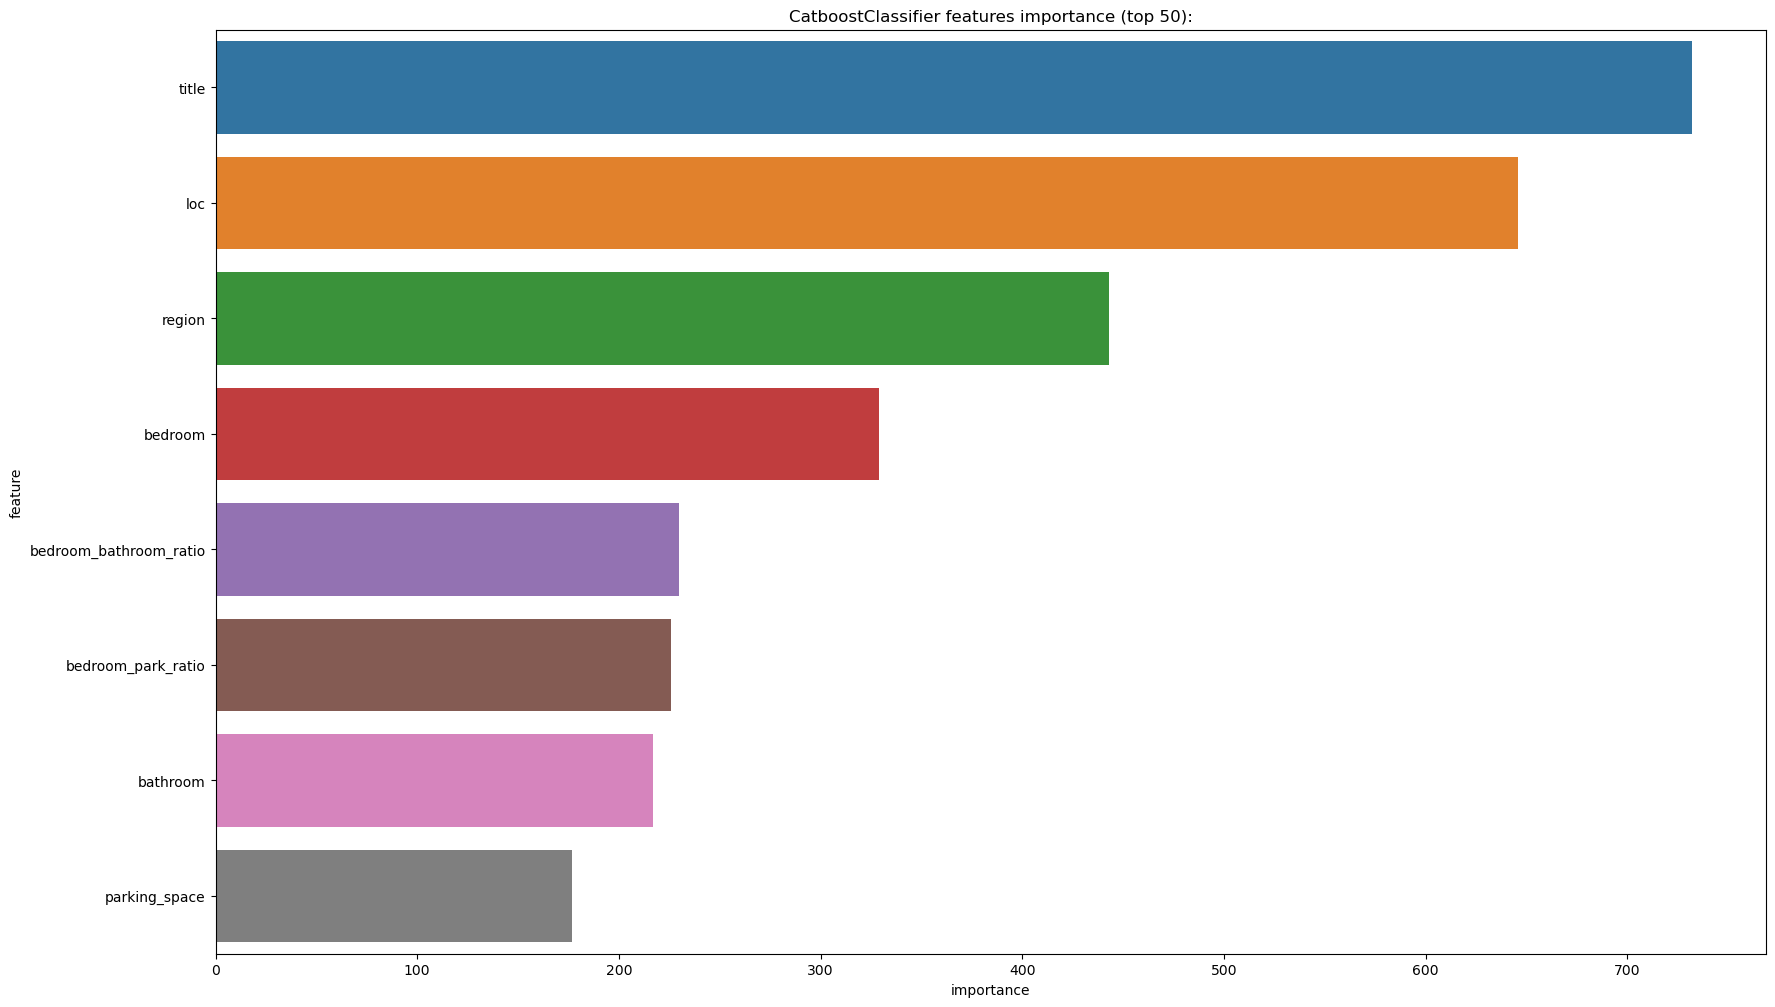

In [32]:
# Feature importance
feat_importance = pd.DataFrame(lgb.feature_importances_, columns=["importance"])

feat_importance["feature"] = X.columns

plt.figure(figsize=(20, 12))
sns.barplot(
    x="importance",
    y="feature",
    data=feat_importance.sort_values(by=["importance"], ascending=False).head(60),
)
plt.title("CatboostClassifier features importance (top 50):")

In [33]:
sample_sub.head()

,ID,price
0,845,2.245801e+06
1,1924,9.451796e+05
2,10718,1.194097e+06
3,12076,7.225594e+06
4,12254,1.839076e+06


In [34]:
sample_sub["price"] = np.mean(fold_pred, axis=0)

In [35]:
sample_sub.head()

,ID,price
0,845,2.269036e+06
1,1924,9.651035e+05
2,10718,1.191876e+06
3,12076,7.706227e+06
4,12254,1.866168e+06


In [36]:
# sample_sub.to_csv("Leeyah_LGB_Submission4.csv", index=False)

In [37]:
# sample_sub.to_csv("Leeyah_LGB_Submission10.csv", index=False)